# Recommendations Systems
## Assignment 3:  Neural Collaborative Filtering

**By:**  

John Doe, 300123123  
Jane Doe, 200123123

<br><br>

**The goal of this assignment is to:**
- Understand the concept of recommendations based on implicit data which is very common in real life.
- Understand how DL components can be used to implement a collaborative filtering & hybrid approach recommenders.
- Understand pros&cons comparing to other recommender system approaches.
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- English only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homwork needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6 should be used. 
- You may use Torch/Keras/TF packeges.
- You should implement the recommender system by yourself using only basic Python libraries (such as numpy).

**LINKS:**
- <a href='https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data'>Dataset</a>
- <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>Repository</a>
- <a href='https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96'>Blog Post Review</a>
<br>

**Google <a href='https://colab.research.google.com/'>Colaboratory</a>**  
        
    This is a great academic tool for students. Instead of installing and running "everything" on your Laptop - which probably will take you a lot of time - you can use Google Colab.  
    Basically, you can use it for all your Python needs.  

**PyTorch <a href='https://pytorch.org/tutorials/beginner/basics/intro.html'>Tutorials</a>**   
    
    Just follow steps 0-7 and you will have the basics skills to understand, build, and run DL recommender models. 

**Keras Kaggle's <a href='https://www.kaggle.com/learn/intro-to-deep-learning'>intro-to-deep-learning</a>**  
    
    This will give you a quick idea of what DL is, and how to utilize it.  
    They're using TensorFlow, while in our MLDL program we're using PyTorch.  




**Grading:**

- Q1 - 20 points - Dataset Preparation
- Q2 - 50 points - Neural Collaborative Filtering
- Q3 - 30 points - Loss Function

`Total: 100`

<br><br><br>

**Prerequisites**

In [ ]:
# !pip install --quiet

**Imports**

In [1]:
# basic
import os 
import sys
import math
import heapq
import argparse
from time import time
import multiprocessing

# general
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import scipy.sparse as sp

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# visual 3D
from mpl_toolkits import mplot3d

# notebook
from IPython.display import display, HTML


# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD


# Keras
# import tensorflow
# from tensorflow import keras
# from tensorflow.keras.models import Model
# from tensorflow.keras import initializers
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.initializers import RandomNormal
# from tensorflow.keras.layers import Dense,Lambda,Activation
# from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
# from tensorflow.keras.models import Sequential,Model,load_model,save_model
# from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import Embedding,Input,Dense,Reshape,Flatten,Dropout,Multiply,Concatenate

# colab
# from google.colab import drive  

**Hide Warnings**

In [2]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

<br><br><br>
<br><br><br>
<br><br><br>

## Question 1: Dataset Preparation (Ingestion)
<br><br>

This implementation contains one file for training and two files for testing:   
- ml-1m.train.rating   
- ml-1m.test.rating  
- ml-1m.test.negative   

<br>
(feel free to use visual explanations)
<br>

a. **Explain** the role and structure of each file and how it was created from the original <a href='https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data'>MovieLens 1M rating dataset</a>.

### ml-1m.train.rating and  ml-1m.test.rating format  \
  user_id - from 0 to 6039 
  movie id - from 0  to 3573
  rating - [1,2,3,4,5]
  timestamp - is represented in seconds since the epoch
 
 in trainning file each user has atleast 19 rows and the maximum is 2313 rows.
 in the test every user has 1 row which is the last rating he gave. 
 
 
  
 
### ml-1m.test.negative  format:  (row numer, user id), list of movies that the user didnt interact with.

Test file (negative instances).
Each line corresponds to the line of test.rating, containing 99 negative samples.
Each line is in the format: (user id, item id)\t negativeItemID1\t negativeItemID2

b. **Explain** how the training dataset is created.

trainning file was created from ratings.dat file.

They used version that contains only users with atleast 20 ratings.

so the tranning set contains atleast 19 rows for every user (last row goes to test).

They took all the user rating except for the last rating (last in time)

c. **Explain** how the test dataset is created.

 The test file contain the last rating every user gave.  
 
 since they used movilen with atleast 20 ratings for every user, so every user has one test rating and at least  
  19 trainning ratings.

#### Data Preperations:

In [4]:
file_train    = 'ml-1m.train.rating'
file_test     = 'ml-1m.test.rating'
file_test_neg = 'ml-1m.test.negative'

In [5]:
train_df = pd.read_csv(file_train,
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

test_df = pd.read_csv(file_test,
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])


def create_negative_dataset(filename):
    negative_rows = []
    with open(filename, "r") as f:
            
            line = f.readline()
            
            while line != None and line != "":
                arr = line.split("\t")
                
                user_id, item_id = eval(arr[0])
                
                negative_itenms = [int(i) for i in line.split('\t')[1:]]
                
                negative_rows.append((user_id, item_id, negative_itenms))
                
                line = f.readline()
                
    
    return pd.DataFrame(negative_rows, columns =['user_id', 'item_id', 'negative_items'])
                

test_negative_df = create_negative_dataset(file_test_neg)

test_negative_df['num_of_negative'] = test_negative_df['negative_items'].apply(len)

train_df.shape[0], test_df.shape[0], test_negative_df.shape[0]

(994169, 6040, 6040)

In [6]:
train_df.sample(3)

,user_id,movie_id,rating,timestamp
218597,1332,1300,3,974777621
527241,3276,565,4,968175667
609548,3715,729,1,966266586


In [7]:
test_df.sample(3)

,user_id,movie_id,rating,timestamp
1872,1872,151,4,982377641
2512,2512,357,5,974072263
399,399,92,3,976294639


In [8]:
test_negative_df.sample(3)

,user_id,item_id,negative_items,num_of_negative
331,331,955,"[2662, 1819, 3349, 1348, 192, 2597, 2791, 2321...",99
5341,5341,471,"[55, 555, 497, 3213, 3593, 3680, 1740, 1891, 7...",99
642,642,237,"[2575, 931, 2901, 1127, 2660, 3560, 1904, 236,...",99


In [9]:
num_negatives = []

users_items_df = train_df.groupby(['user_id'])['movie_id'].apply(set).reset_index()

users_items_df.sample(3)


num_of_positives_per_user = 20 #train_df.shape[0]/users_items_df.shape[0]

all_items = set(train_df['movie_id'].tolist())

dataset_rows = []

for (_, user_items_row) in users_items_df.iterrows():
    
    user_id = user_items_row['user_id']
    user_items = user_items_row['movie_id'] 
    
    for item_id in user_items:
        dataset_rows.append((user_id, item_id, 1))
        
    user_uninteracted_items = list(all_items - user_items)
    
    user_selected_uninteraccted_items = np.random.choice(user_uninteracted_items, num_of_positives_per_user, replace=False)
    
    
    for item_id in user_selected_uninteraccted_items:
        dataset_rows.append((user_id, item_id, 0))
        
        

train_dataset_df = pd.DataFrame(dataset_rows, columns =['user_id', 'item_id', 'label'])
    
train_dataset_df.shape[0]
    

1114969

In [10]:
train_dataset_df.sample(3)

,user_id,item_id,label
600029,3310,2747,1
196007,1108,1087,1
84195,508,78,1


In [12]:
class DatasetLoader(Dataset):
    
    def __init__(self, df):
        self._df = df.sample(frac=1.0)
    
    def __len__(self):
        return len(self._df)
    
    def __getitem__(self, idx):
        
        row = self._df.iloc[idx]
        item_id = row['item_id']
        user_id = row['user_id']
        label = row['label']
        
        
        return item_id, user_id, label

In [13]:
n_users = np.max(train_df.user_id.tolist()) + 1
n_items = np.max(train_df.movie_id.tolist()) + 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128
n_users, n_items, BATCH_SIZE, device

(6040, 3706, 128, device(type='cpu'))

In [14]:

train_dataset = DatasetLoader(train_dataset_df)

train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


<br><br><br>
<br><br><br>
<br><br><br>

## Question 2: Neural Collaborative Filtering 
<br><br>

## a. Build the following four models using the neural collaborative filtering approach: 
- Matrix Factorization (MF)
- Multi layer perceptron (MLP)
- Generalized Matrix Factorization (GMF) 
- NeuroMatrixFactorization (NMF)


<br><br><br><br>
**Matrix Factorization (MF)**

<br>

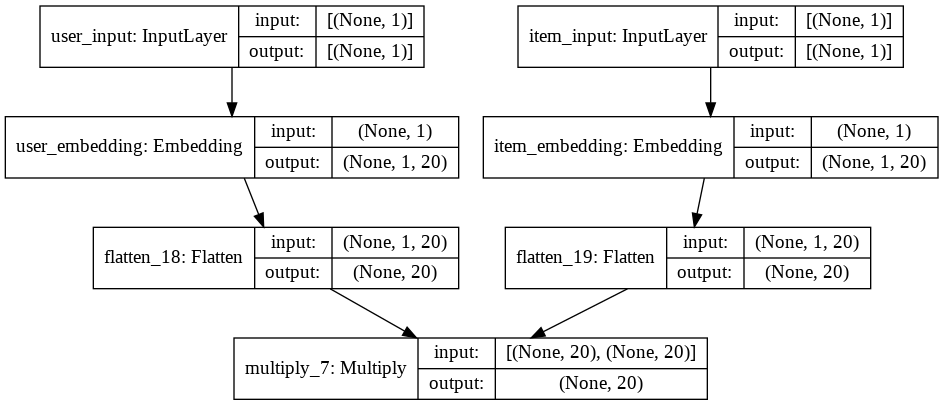

In [15]:
class MF(nn.Module):
    def __init__(self, n_users, n_items, n_latent):
        super(MF, self).__init__()

        self.users_embeddings = Embedding(n_users, n_latent)
        self.items_embeddings = Embedding(n_items, n_latent)

        self.fc1 = Linear(n_latent, 1)
        self.af = Sigmoid()

    def forward(self, users_ids, items_ids):
        users_latens = self.users_embeddings(users_ids)
        items_latents = self.items_embeddings(items_ids)

        x = torch.mul(users_latens, items_latents)
        x = self.fc1(x)
        x = self.af(x)

        
model_MF = MF(n_users,n_items, 8)

<br><br><br><br><br><br>
**Multi Layer Perceptron (MLP)**
<br>
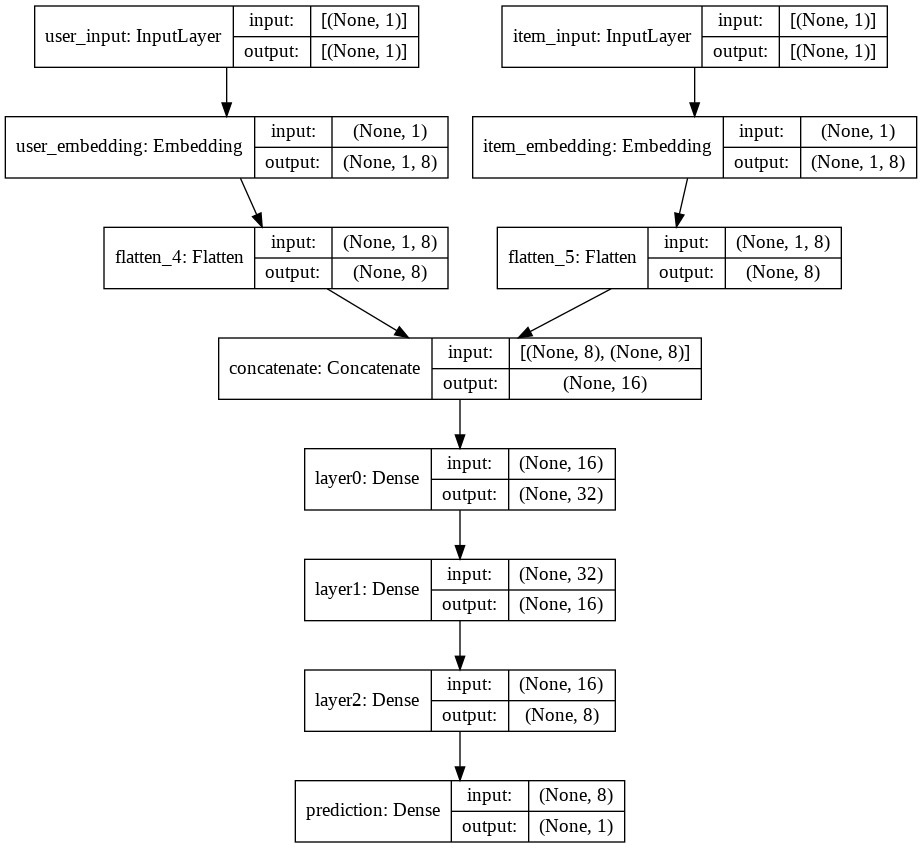

In [16]:
class MLP(nn.Module):
    def __init__(self, n_users, n_items, n_latent=8, fc_layers=[32, 16, 8]):
        super(MLP, self).__init__()

        self.users_embeddings = Embedding(n_users, n_latent)
        self.items_embeddings = Embedding(n_items, n_latent)

        self.fc_layers = torch.nn.ModuleList()

        for idx, (in_size, out_size) in enumerate(zip(fc_layers[:-1], fc_layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=fc_layers[-1], out_features=1)

        self.af = Sigmoid()

    def forward(self, users_ids, items_ids):

        user_embedding = self.users_embeddings(users_ids)
        item_embedding = self.items_embeddings(items_ids)

        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)

        vector = self.affine_output(vector)
        rating = self.af(vector)
        return rating

    
 
model_MLP = MLP(n_users,n_items, n_latent = 8, fc_layers = [16, 32, 16, 8, 1])

<br><br><br><br><br><br>
**Generalized Matrix Factorization (GMF)**
<br>
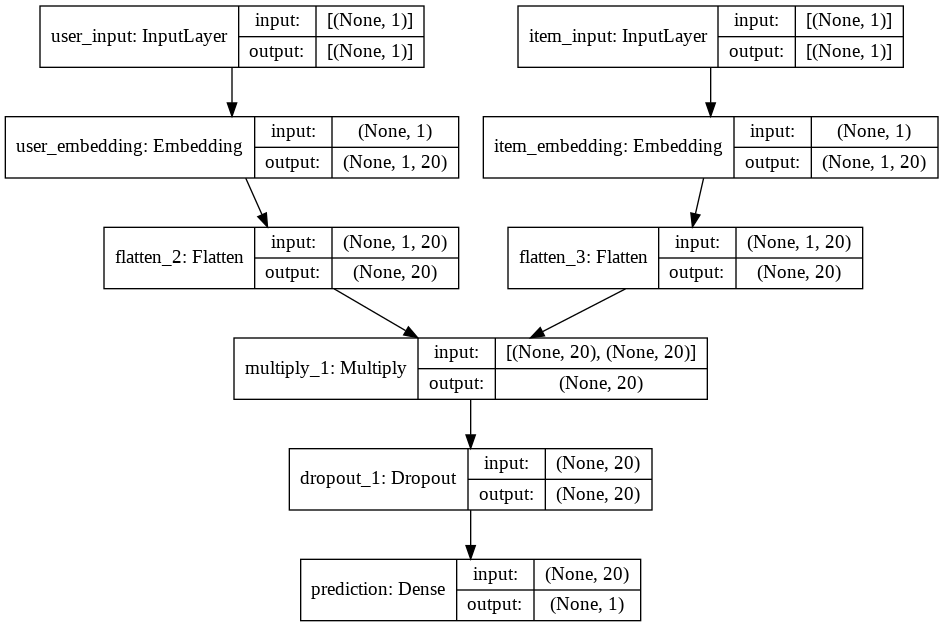

In [17]:
class GMF(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_latent):
    
        super(GMF, self).__init__()

        self.users_embeddings = torch.nn.Embedding(num_embeddings=n_users, embedding_dim=n_latent)
        self.items_embeddings = torch.nn.Embedding(num_embeddings=n_items, embedding_dim=n_latent)

        self.fc1 = torch.nn.Linear(in_features=n_latent, out_features=1)
        self.dp1 = nn.Dropout(p=0.2)
        self.sig = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        
        
        users_embedding = self.users_embeddings(user_indices)
        items_embedding = self.items_embeddings(item_indices)
        
        users_items_product = torch.mul(users_embedding, items_embedding)
        users_items_product = self.dp1(users_items_product)
        
        logits = self.fc1(users_items_product)
        rating = self.sig(logits)
        return rating


model_GMF = GMF(n_users,n_items, n_latent = 8)

<br><br><br><br><br><br>
**NeuroMatrixFactorization (NMF)**

<br>

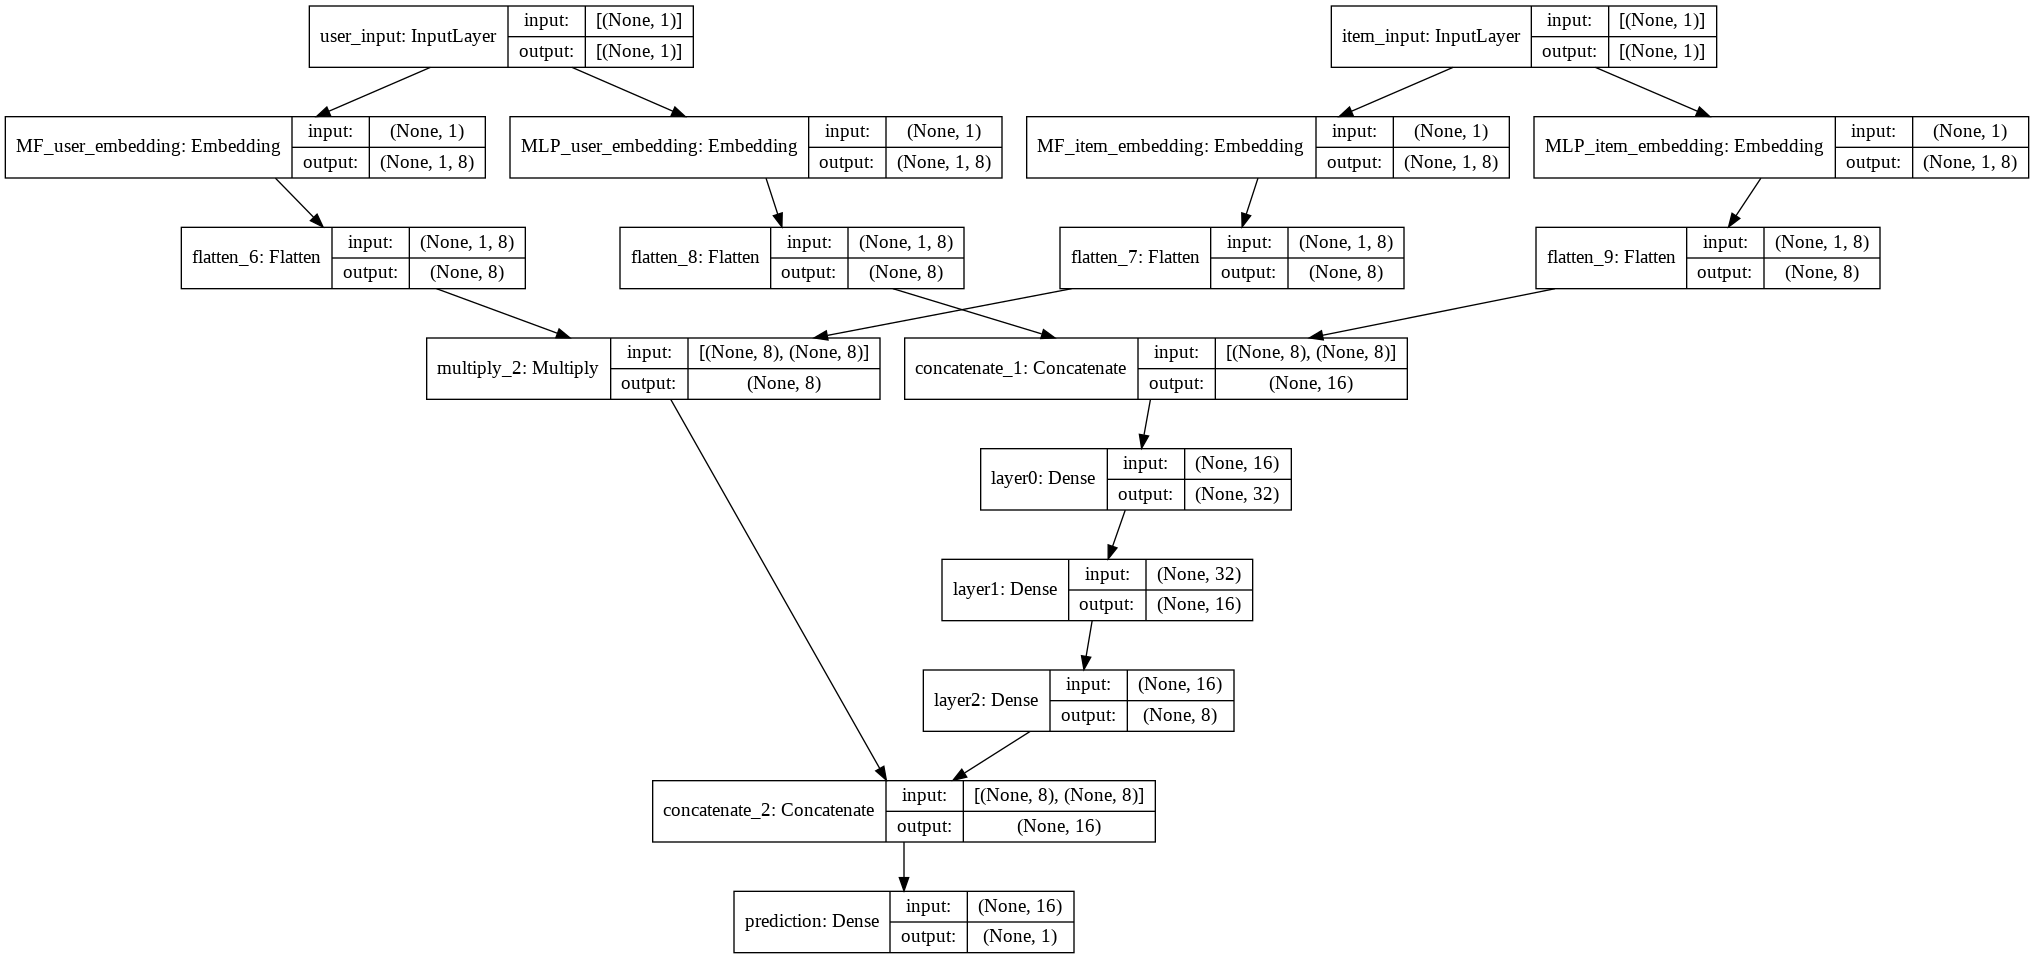

In [18]:
class NMF(torch.nn.Module):
    def __init__(self, n_users, n_items, n_latent_mf, n_latent_mlp, layers):
        
        super(NMF, self).__init__()

        self.users_embedding_mlp = torch.nn.Embedding(num_embeddings=n_users, embedding_dim=n_latent_mlp)
        self.items_embedding_mlp = torch.nn.Embedding(num_embeddings=n_items, embedding_dim=n_latent_mlp)
        
        self.users_embedding_mf =  torch.nn.Embedding(num_embeddings=n_users, embedding_dim=n_latent_mf)
        self.items_embedding_mf =  torch.nn.Embedding(num_embeddings=n_items, embedding_dim=n_latent_mf)

        self.fc_layers = torch.nn.ModuleList()
        for (in_size, out_size) in zip(layers[:-1], layers[1:]):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        
        
        
        self.affine_output = torch.nn.Linear(in_features=layers[-1] +  n_latent_mf, out_features=1)
        self.sig1 = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        
        user_embedding_mlp = self.users_embedding_mlp(user_indices)
        item_embedding_mlp = self.items_embedding_mlp(item_indices)
        
        user_embedding_mf = self.users_embedding_mf(user_indices)
        item_embedding_mf = self.items_embedding_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1) 
        
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        
        rating = self.sig1(logits)
        return rating
    

model_NMF = NMF(n_users, n_items, 8, 8, [16,32, 8])

<br><br><br><br><br><br>

## b. Train and evaluate the recommendations accuracy of the models: 
- MF
- GMF
- MLP
- NMF

Compare the learning curve and recommendations accuracy using NDCG and MRR metrics with cutoff values of 5 and 10.   
Discuss the comparison. 

**Metrics:**
- HitRatio
- nDCG
- MRR

In [ ]:
def train(model, lr=0.001, n_epochs = 100):

    model.to(device)

    criterion = nn.BCELoss()
    criterion.to(device)

    optimizer = Adam(model.parameters(), lr=lr)
    loss_values = []

    for epoch in range(n_epochs): 

        running_loss = 0.0
        for i, (items_ids, users_ids, labels) in enumerate(train_data_loader, 0):

            labels = labels.float().to(device)
            items_ids = items_ids.to(device)
            users_ids = users_ids.to(device)


            optimizer.zero_grad()
            outputs = model(users_ids, items_ids).flatten()

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.detach().cpu().item()

        loss_values.append(running_loss / len(train_data_loader))

train(model_NMF)

In [13]:
# Use your own metrics implementation OR use external packages for the metrics.
# If you are using external packages make sure they work properly. 
# A lot of the packages available does not work as you would expect.

**Evaluation:**

**HyperParams:**

In [14]:
# the choosen hyperparams will effect your models & your grade 

<br><br>
Create train data:

<br><br>
train & eval:

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
All Results:

In [49]:
# df_results
# each hyperparam will add a column to the dataframe
# this is an example for a df that would allow you to create plots easily

,model,topk,metric,score
0,MF,0,TIME,2.68642e+06
1,MF,0,LOSS,"[1.7666953802108765, 1.7452603578567505, 1.743..."
2,MF,5,HR,0.22798
3,MF,5,NDCG,0.153461
4,MF,5,MRR,0.129026
5,MF,10,HR,0.322682
6,MF,10,NDCG,0.184213
7,MF,10,MRR,0.141787
8,MLP,0,TIME,2.68642e+06
9,MLP,0,LOSS,"[0.3481043875217438, 0.31486931443214417, 0.29..."


<br><br><br><br>
Train & Validation Loss:

In [1]:
# plot
# make sure that you did not overfit

Training Time:

In [2]:
# plot

Metric Evaluation:

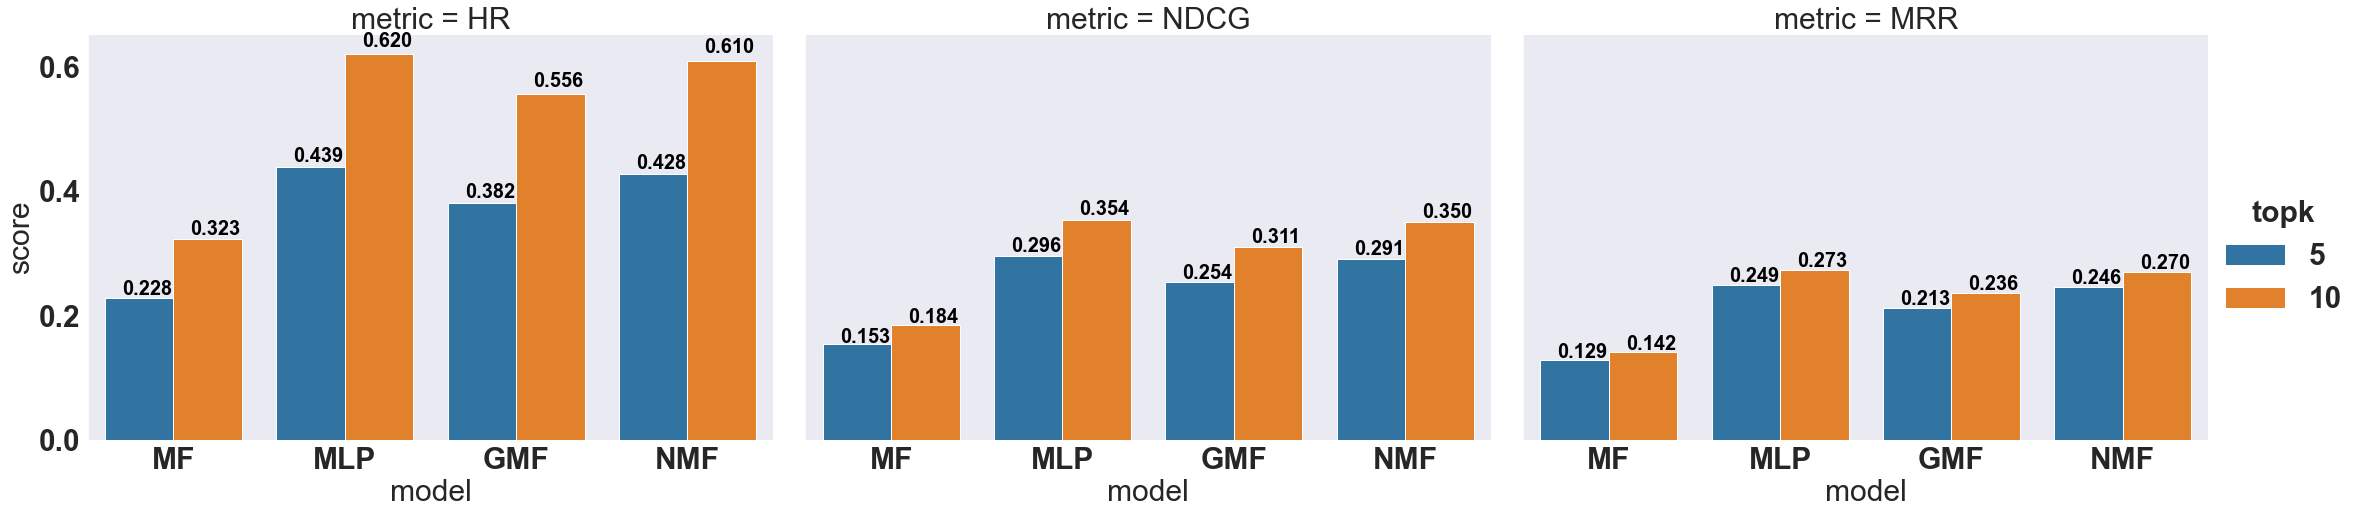

In [25]:
# plot suggestion/example - you may create your own plot (you should achieve higher results)

<br><br><br><br>
<br><br><br><br>

**c. How the values of MRR and NDCG are differ from the results you got in the previous exercises which implemented the explicit recommendation approach. What are the difference in preparing the dataset for evaluation.**

**d. How will you measure item similarity using the NeuMF model?**

<br><br><br>
<br><br><br>
<br><br><br>

## Question 3: Loss Function 
<br><br>

#### a. One of the enhancements presented in the Neural Collaborative Filtering paper is the usage of probabilistic activation function (the sigmoid) and binary cross entropy loss function.   

Select one of the models you implemented in question 2 and change the loss function to a `Mean Squared Error` and the activation function of the last layer to `RELU`.   

Train the model and evaluate it in a similar way to what you did in question 2. 
Compare the results and discuss.

<br><br><br><br>
<br><br><br><br>
NMFs Results:

In [6]:
# example: df_results[df_results.model.str.startswith('NMF')]

<br><br><br>
<br><br><br>

Train & Validation Loss:

In [3]:
# plot

<br><br><br>
Training Time:

In [4]:
# plot

<br><br><br>
Metric Evaluation:

In [5]:
# plot

<br><br><br><br>
**Conclusions:**

    - In
    - Your
    - Own
    - Words
    

<br><br>
<br><br>


Good Luck :)

In [ ]:
# Recommendations Systems
## Assignment 3:  Neural Collaborative Filtering

**By:**  

John Doe, 300123123  
Jane Doe, 200123123

<br><br>

**The goal of this assignment is to:**
- Understand the concept of recommendations based on implicit data which is very common in real life.
- Understand how DL components can be used to implement a collaborative filtering & hybrid approach recommenders.
- Understand pros&cons comparing to other recommender system approaches.
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- English only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homwork needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6 should be used. 
- You may use Torch/Keras/TF packeges.
- You should implement the recommender system by yourself using only basic Python libraries (such as numpy).

**LINKS:**
- <a href='https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data'>Dataset</a>
- <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>Repository</a>
- <a href='https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96'>Blog Post Review</a>
<br>

**Google <a href='https://colab.research.google.com/'>Colaboratory</a>**  
        
    This is a great academic tool for students. Instead of installing and running "everything" on your Laptop - which probably will take you a lot of time - you can use Google Colab.  
    Basically, you can use it for all your Python needs.  

**PyTorch <a href='https://pytorch.org/tutorials/beginner/basics/intro.html'>Tutorials</a>**   
    
    Just follow steps 0-7 and you will have the basics skills to understand, build, and run DL recommender models. 

**Keras Kaggle's <a href='https://www.kaggle.com/learn/intro-to-deep-learning'>intro-to-deep-learning</a>**  
    
    This will give you a quick idea of what DL is, and how to utilize it.  
    They're using TensorFlow, while in our MLDL program we're using PyTorch.  




**Grading:**

- Q1 - 20 points - Dataset Preparation
- Q2 - 50 points - Neural Collaborative Filtering
- Q3 - 30 points - Loss Function

`Total: 100`

<br><br><br>

**Prerequisites**

# !pip install --quiet

**Imports**

# basic
import os 
import sys
import math
import heapq
import argparse
from time import time
import multiprocessing

# general
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import scipy.sparse as sp

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# visual 3D
from mpl_toolkits import mplot3d

# notebook
from IPython.display import display, HTML


# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD


# Keras
# import tensorflow
# from tensorflow import keras
# from tensorflow.keras.models import Model
# from tensorflow.keras import initializers
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.initializers import RandomNormal
# from tensorflow.keras.layers import Dense,Lambda,Activation
# from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
# from tensorflow.keras.models import Sequential,Model,load_model,save_model
# from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import Embedding,Input,Dense,Reshape,Flatten,Dropout,Multiply,Concatenate

# colab
# from google.colab import drive  

**Hide Warnings**

warnings.filterwarnings('ignore')

**Disable Autoscrolling**

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<br><br><br>
<br><br><br>
<br><br><br>

## Question 1: Dataset Preparation (Ingestion)
<br><br>

This implementation contains one file for training and two files for testing:   
- ml-1m.train.rating   
- ml-1m.test.rating  
- ml-1m.test.negative   

<br>
(feel free to use visual explanations)
<br>

a. **Explain** the role and structure of each file and how it was created from the original <a href='https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data'>MovieLens 1M rating dataset</a>.

### ml-1m.train.rating and  ml-1m.test.rating format  \
  user_id - from 0 to 6039 
  movie id - from 0  to 3573
  rating - [1,2,3,4,5]
  timestamp - is represented in seconds since the epoch
 
 in trainning file each user has atleast 19 rows and the maximum is 2313 rows.
 in the test every user has 1 row which is the last rating he gave. 
 
 
  
 
### ml-1m.test.negative  format:  (row numer, user id), list of movies that the user didnt interact with.

Test file (negative instances).
Each line corresponds to the line of test.rating, containing 99 negative samples.
Each line is in the format: (user id, item id)\t negativeItemID1\t negativeItemID2

b. **Explain** how the training dataset is created.

trainning file was created from ratings.dat file.

They used version that contains only users with atleast 20 ratings.

so the tranning set contains atleast 19 rows for every user (last row goes to test).

They took all the user rating except for the last rating (last in time)

train_df.sample(3)

c. **Explain** how the test dataset is created.

 The test file contain the last rating every user gave.  
 
 since they used movilen with atleast 20 ratings for every user, so every user has one test rating and at least  
  19 trainning ratings.

#### Data Preperations:

file_train    = 'ml-1m.train.rating'
file_test     = 'ml-1m.test.rating'
file_test_neg = 'ml-1m.test.negative'

train_df = pd.read_csv(file_train,
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

test_df = pd.read_csv(file_test,
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])



# test_negative_df = pd.read_csv(file_test_neg,
#                     sep='\t', 
#                     engine='python', 
#                     encoding='latin-1',
#                     names=['user_id', 'movieid', 'rating', 'timestamp'])



train_df.sample(3)

test_df.sample(2)

<br><br><br>
<br><br><br>
<br><br><br>

## Question 2: Neural Collaborative Filtering 
<br><br>

## a. Build the following four models using the neural collaborative filtering approach: 
- Matrix Factorization (MF)
- Multi layer perceptron (MLP)
- Generalized Matrix Factorization (GMF) 
- NeuroMatrixFactorization (NMF)


<br><br><br><br>
**Matrix Factorization (MF)**

<br>

![image.png](attachment:image.png)

model_MF = None

<br><br><br><br><br><br>
**Multi Layer Perceptron (MLP)**
<br>
![image.png](attachment:image.png)

model_MLP = None

<br><br><br><br><br><br>
**Generalized Matrix Factorization (GMF)**
<br>
![image.png](attachment:image.png)

model_GMF = None

<br><br><br><br><br><br>
**NeuroMatrixFactorization (NMF)**

<br>

![image.png](attachment:image.png)

model_NMF = None

<br><br><br><br><br><br>

## b. Train and evaluate the recommendations accuracy of the models: 
- MF
- GMF
- MLP
- NMF

Compare the learning curve and recommendations accuracy using NDCG and MRR metrics with cutoff values of 5 and 10.   
Discuss the comparison. 

**Metrics:**
- HitRatio
- nDCG
- MRR

# Use your own metrics implementation OR use external packages for the metrics.
# If you are using external packages make sure they work properly. 
# A lot of the packages available does not work as you would expect.

**Evaluation:**





**HyperParams:**

# the choosen hyperparams will effect your models & your grade 

<br><br>
Create train data:



<br><br>
train & eval:



<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
All Results:

# df_results
# each hyperparam will add a column to the dataframe
# this is an example for a df that would allow you to create plots easily

<br><br><br><br>
Train & Validation Loss:

# plot
# make sure that you did not overfit

Training Time:

# plot

Metric Evaluation:

# plot suggestion/example - you may create your own plot (you should achieve higher results)

<br><br><br><br>
<br><br><br><br>

**c. How the values of MRR and NDCG are differ from the results you got in the previous exercises which implemented the explicit recommendation approach. What are the difference in preparing the dataset for evaluation.**



**d. How will you measure item similarity using the NeuMF model?**



<br><br><br>
<br><br><br>
<br><br><br>

## Question 3: Loss Function 
<br><br>

#### a. One of the enhancements presented in the Neural Collaborative Filtering paper is the usage of probabilistic activation function (the sigmoid) and binary cross entropy loss function.   

Select one of the models you implemented in question 2 and change the loss function to a `Mean Squared Error` and the activation function of the last layer to `RELU`.   

Train the model and evaluate it in a similar way to what you did in question 2. 
Compare the results and discuss.



<br><br><br><br>
<br><br><br><br>
NMFs Results:

# example: df_results[df_results.model.str.startswith('NMF')]

<br><br><br>
<br><br><br>

Train & Validation Loss:

# plot

<br><br><br>
Training Time:

# plot

<br><br><br>
Metric Evaluation:

# plot

<br><br><br><br>
**Conclusions:**

    - In
    - Your
    - Own
    - Words
    

<br><br>
<br><br>


Good Luck :)